### Remote work impacts on health

#### Description 
The Post-Pandemic Remote Work Health Impact 2025 dataset presents a comprehensive, global snapshot of how remote, hybrid, and onsite work arrangements are influencing the mental and physical health of employees in the post-pandemic era. Collected in June 2025, this dataset aggregates responses from a diverse workforce spanning continents, industries, age groups, and job roles. It is designed to support research, data analysis, and policy-making around the evolving landscape of work and well-being.

This dataset enables in-depth exploration of:

The prevalence of mental health conditions (e.g., anxiety, burnout, PTSD, depression) across different work setups.
The relationship between work arrangements and physical health complaints (e.g., back pain, eye strain, neck pain).
Variations in work-life balance, social isolation, and burnout levels segmented by demographic and occupational factors.
Salary distributions and their correlation with health outcomes and job roles.
By providing granular, anonymized data on both subjective (self-reported) and objective (hours worked, salary range) factors, this resource empowers data scientists, health researchers, HR professionals, and business leaders to:

Identify risk factors and protective factors for employee well-being.
Benchmark health impacts across industries and regions.
Inform organizational policy and future-of-work strategies.

In [1]:
import pandas as pd
import numpy as np 
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OrdinalEncoder

# dt imports 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

import seaborn as sns
from sklearn import tree


from imblearn.over_sampling import SMOTE

pd.set_option("display.max_columns", None)

api = KaggleApi()
api.authenticate()

api.dataset_download_files(
    'kshitijsaini121/remote-work-of-health-impact-survey-june-2025',
    path='data/',
    unzip=True 
)

df = pd.read_csv("data/post_pandemic_remote_work_health_impact_2025.csv", parse_dates=['Survey_Date'])

print(f"Shape of the Data: {df.shape}")


df.head()

Dataset URL: https://www.kaggle.com/datasets/kshitijsaini121/remote-work-of-health-impact-survey-june-2025
Shape of the Data: (3157, 14)


,Survey_Date,Age,Gender,Region,Industry,Job_Role,Work_Arrangement,Hours_Per_Week,Mental_Health_Status,Burnout_Level,Work_Life_Balance_Score,Physical_Health_Issues,Social_Isolation_Score,Salary_Range
0,2025-06-01,27,Female,Asia,Professional Services,Data Analyst,Onsite,64,Stress Disorder,High,3,Shoulder Pain; Neck Pain,2,$40K-60K
1,2025-06-01,37,Female,Asia,Professional Services,Data Analyst,Onsite,37,Stress Disorder,High,4,Back Pain,2,$80K-100K
2,2025-06-01,32,Female,Africa,Education,Business Analyst,Onsite,36,ADHD,High,3,Shoulder Pain; Eye Strain,2,$80K-100K
3,2025-06-01,40,Female,Europe,Education,Data Analyst,Onsite,63,ADHD,Medium,1,Shoulder Pain; Eye Strain,2,$60K-80K
4,2025-06-01,30,Male,South America,Manufacturing,DevOps Engineer,Hybrid,65,NaN,Medium,5,NaN,4,$60K-80K


## Data Cleaning 

Missing Values and Outlier Detection 

In [2]:
df.describe()

,Survey_Date,Age,Hours_Per_Week,Work_Life_Balance_Score,Social_Isolation_Score
count,3157,3157.000000,3157.000000,3157.000000,3157.000000
mean,2025-06-13 13:29:37.763699712,43.732024,49.904973,2.996516,2.704783
min,2025-06-01 00:00:00,22.000000,35.000000,1.000000,1.000000
25%,2025-06-07 00:00:00,33.000000,42.000000,2.000000,2.000000
50%,2025-06-14 00:00:00,44.000000,50.000000,3.000000,3.000000
75%,2025-06-20 00:00:00,55.000000,57.000000,4.000000,4.000000
max,2025-06-26 00:00:00,65.000000,65.000000,5.000000,5.000000
std,NaN,12.661095,8.897699,1.163307,1.188887


In [3]:
isna_cols = df.isna().sum()

print(isna_cols)

Survey_Date                  0
Age                          0
Gender                       0
Region                       0
Industry                     0
Job_Role                     0
Work_Arrangement             0
Hours_Per_Week               0
Mental_Health_Status       799
Burnout_Level                0
Work_Life_Balance_Score      0
Physical_Health_Issues     280
Social_Isolation_Score       0
Salary_Range                 0
dtype: int64


In [4]:
print(df['Mental_Health_Status'].value_counts())

Mental_Health_Status
PTSD               423
Anxiety            394
Burnout            392
Depression         386
ADHD               385
Stress Disorder    378
Name: count, dtype: int64


In [5]:
# Replace missing values in this column with 'None' because that was what was indicated in the documentation
df['Mental_Health_Status'] = df['Mental_Health_Status'].fillna('None')

In [6]:
print(df['Mental_Health_Status'].value_counts())

Mental_Health_Status
None               799
PTSD               423
Anxiety            394
Burnout            392
Depression         386
ADHD               385
Stress Disorder    378
Name: count, dtype: int64


## Data Engineering (Prep for models) 

In [7]:
# change Burnout Level from 1 to 3
df['Burnout_Level'].value_counts()

df['Burnout_Level'] = df['Burnout_Level'].replace({
    'Low': 1,
    'Medium' : 2,
    'High': 3
})

/var/folders/tm/zd2ldwcj6w5cml9j9n1_pcsr0000gn/T/ipykernel_45292/3335120009.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Burnout_Level'] = df['Burnout_Level'].replace({


In [8]:
# one-hot encode the mutli-valued columns 
lists = (
    df['Physical_Health_Issues']
      .fillna('None') # NaN indicates no physical health issues
      .str.split(';')
      .apply(lambda L: [item.strip() for item in L if item.strip()])
)

mlb = MultiLabelBinarizer()
onehot = mlb.fit_transform(lists)

prefix = "Physical_Health_"
cols   = [f"{prefix}{cat}" for cat in mlb.classes_]

onehot_physical_health = pd.DataFrame(
    onehot,
    columns=cols,
    index=df.index
)

df.drop("Physical_Health_Issues", axis = 1, inplace = True)

df_onehot = pd.concat([df, onehot_physical_health], axis = 1)


In [9]:
def return_likert_to_binary(df, col):
    ind_col = f"{col}_ind"
    print(f"Converting column {col} to binary → {ind_col}")
    df[ind_col] = np.where(df[col] >= 4, 1, 0)
    return df

df_onehot = return_likert_to_binary(df_onehot, "Work_Life_Balance_Score")
df_onehot = return_likert_to_binary(df_onehot, "Social_Isolation_Score")

Converting column Work_Life_Balance_Score to binary → Work_Life_Balance_Score_ind
Converting column Social_Isolation_Score to binary → Social_Isolation_Score_ind


In [10]:
cat_vars = df.select_dtypes(include = ['object', 'category']).columns.to_list()

print(f"List of Categorical Variables to be one-hot encoded: {cat_vars}")

# def fn to one-hot for decision tree 
def one_hot_encode(df, cols): 
    return pd.get_dummies(
        df, 
        columns=cols, 
        prefix=cols, 
        dtype = int
    )

df_encoded = one_hot_encode(df, cat_vars)

List of Categorical Variables to be one-hot encoded: ['Gender', 'Region', 'Industry', 'Job_Role', 'Work_Arrangement', 'Mental_Health_Status', 'Salary_Range']


In [11]:
def plot_histogram(df, cols, bins = 10, figsize = (8,4)): 
    for col in cols: 
        plt.figure(figsize=figsize)

        df[col].dropna().hist(bins = bins)

        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation = 90)
        plt.tight_layout()
        plt.show()

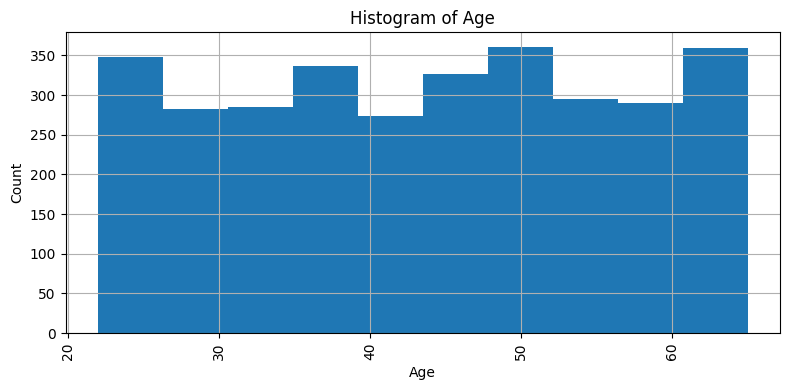

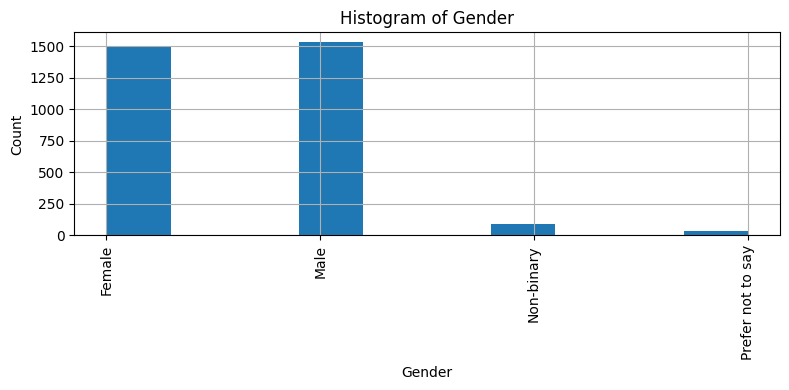

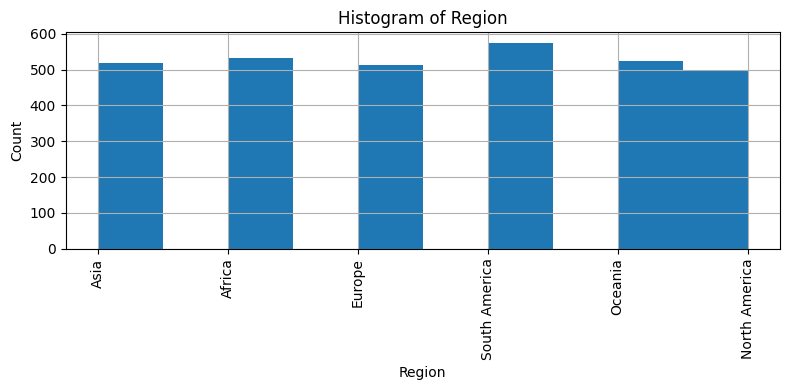

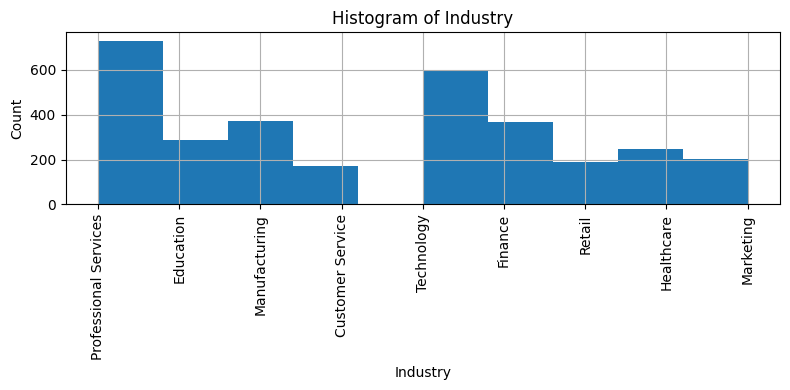

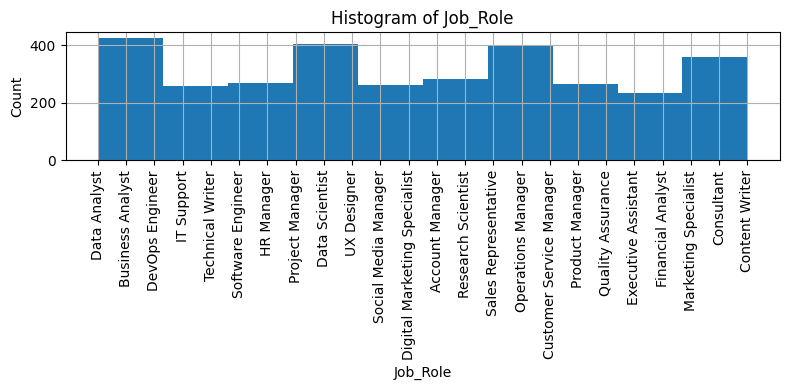

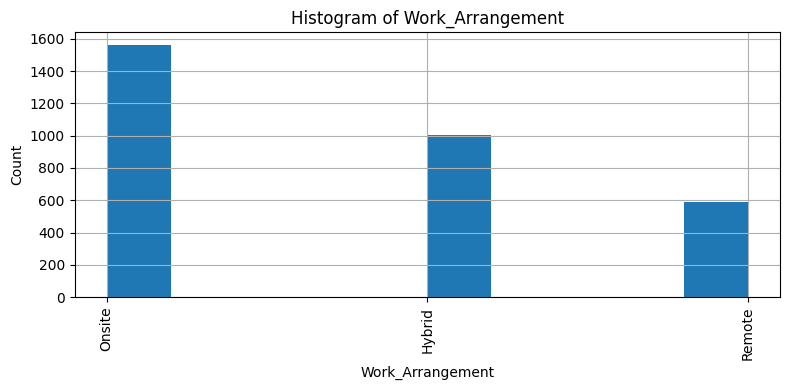

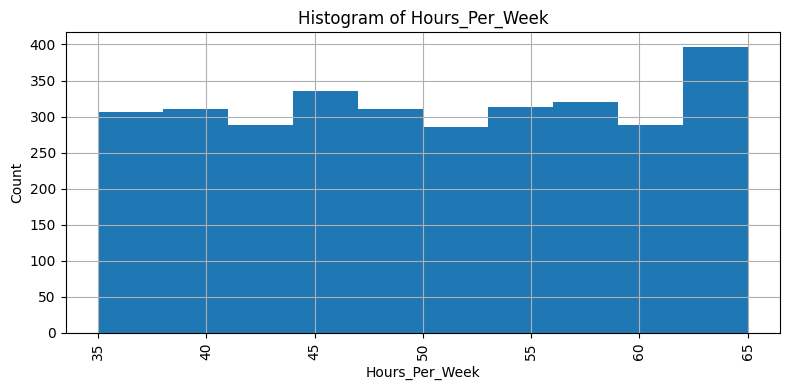

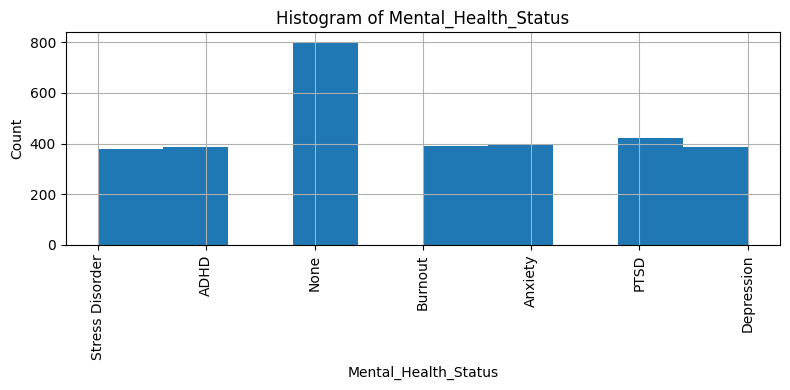

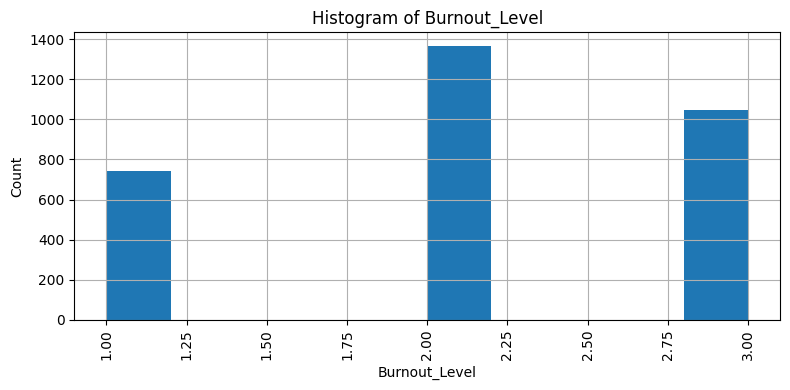

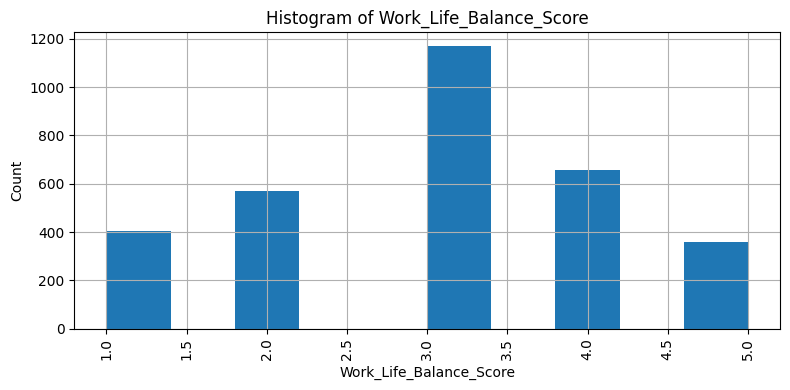

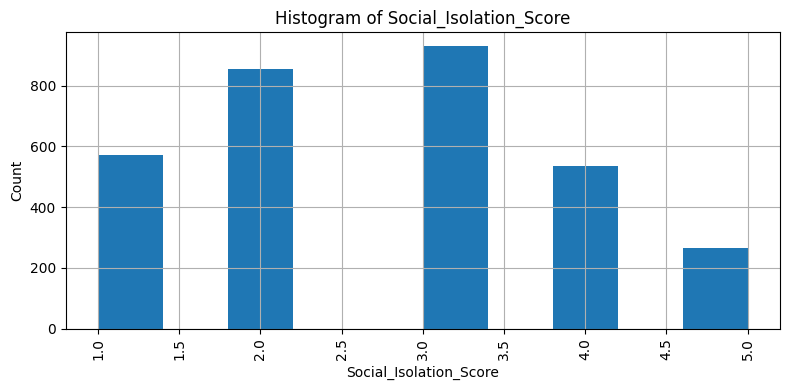

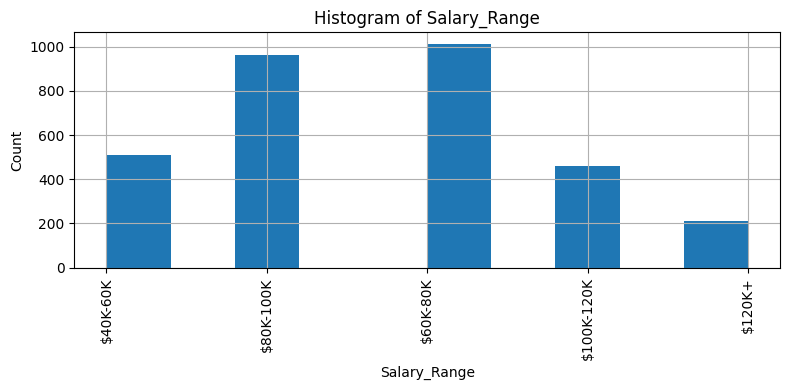

In [12]:
plot_histogram(df, ['Age', 'Gender', 'Region', 'Industry', 'Job_Role', 'Work_Arrangement', 'Hours_Per_Week', 'Mental_Health_Status', 'Burnout_Level', 'Work_Life_Balance_Score', 
                    'Social_Isolation_Score', 'Salary_Range'])

## Model Development

---- 

#### Decision Tree

In [13]:
df_encoded.head(5)

,Survey_Date,Age,Hours_Per_Week,Burnout_Level,Work_Life_Balance_Score,Social_Isolation_Score,Gender_Female,Gender_Male,Gender_Non-binary,Gender_Prefer not to say,Region_Africa,Region_Asia,Region_Europe,Region_North America,Region_Oceania,Region_South America,Industry_Customer Service,Industry_Education,Industry_Finance,Industry_Healthcare,Industry_Manufacturing,Industry_Marketing,Industry_Professional Services,Industry_Retail,Industry_Technology,Job_Role_Account Manager,Job_Role_Business Analyst,Job_Role_Consultant,Job_Role_Content Writer,Job_Role_Customer Service Manager,Job_Role_Data Analyst,Job_Role_Data Scientist,Job_Role_DevOps Engineer,Job_Role_Digital Marketing Specialist,Job_Role_Executive Assistant,Job_Role_Financial Analyst,Job_Role_HR Manager,Job_Role_IT Support,Job_Role_Marketing Specialist,Job_Role_Operations Manager,Job_Role_Product Manager,Job_Role_Project Manager,Job_Role_Quality Assurance,Job_Role_Research Scientist,Job_Role_Sales Representative,Job_Role_Social Media Manager,Job_Role_Software Engineer,Job_Role_Technical Writer,Job_Role_UX Designer,Work_Arrangement_Hybrid,Work_Arrangement_Onsite,Work_Arrangement_Remote,Mental_Health_Status_ADHD,Mental_Health_Status_Anxiety,Mental_Health_Status_Burnout,Mental_Health_Status_Depression,Mental_Health_Status_None,Mental_Health_Status_PTSD,Mental_Health_Status_Stress Disorder,Salary_Range_$100K-120K,Salary_Range_$120K+,Salary_Range_$40K-60K,Salary_Range_$60K-80K,Salary_Range_$80K-100K
0,2025-06-01,27,64,3,3,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
1,2025-06-01,37,37,3,4,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,2025-06-01,32,36,3,3,2,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
3,2025-06-01,40,63,2,1,2,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
4,2025-06-01,30,65,2,5,4,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [14]:
# Initalize New Dataframe for Decision Tree
X = df_encoded.drop(columns = [
    'Survey_Date',
    'Work_Life_Balance_Score',
    'Social_Isolation_Score'
])

y1 = df['Work_Life_Balance_Score']
y2 = df['Social_Isolation_Score']

X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size= 0.3, random_state = 123)
_      , _    , y2_train, y2_test = train_test_split(X, y2, test_size = 0.3, random_state = 123)

X_train.items()

def shape_prnt(**vars):
    """
    Print the .shape of each variable passed as a keyword argument.
    Usage:
      shape_prnt(X_train=X_train, X_test=X_test, y1_train=y1_train)
    """
    for name, arr in vars.items():
        if hasattr(arr, 'shape'):
            print(f"Shape of {name}: {arr.shape}")
        else:
            print(f"{name!r} has no .shape attribute")

shape_prnt(
    X_train=X_train,
    X_test=X_test,
    y1_train=y1_train,
    y1_test=y1_test,
    y2_train=y2_train,
    y2_test=y2_test
)


Shape of X_train: (2209, 61)
Shape of X_test: (948, 61)
Shape of y1_train: (2209,)
Shape of y1_test: (948,)
Shape of y2_train: (2209,)
Shape of y2_test: (948,)


### Start Model Development

#### Model 1: Regular Decision Tree Method

In [15]:
# clf_wlb = DecisionTreeClassifier(
#     max_depth=15,
#     min_samples_split=30,
#     min_samples_leaf=10,
#     random_state=42
# )

# clf_wlb.fit(X_train, y1_train)

# plt.figure(figsize=(150,30))

# tree.plot_tree(
#     clf_wlb, 
#     filled = True, 
#     rounded = True, 
#     feature_names= X.columns,
#     class_names = [str(c) for c in clf_wlb.classes_], 
#     fontsize=10
# )

# plt.show()

#### Model 2: GridSearch Method

In [16]:
## Grid Search Method 
param_grid = {
    'criterion':            ['gini', 'entropy'],
    'max_depth':            [3,5,6,7,15,20], 
    'min_samples_split':    [10,15,20], 
    'min_samples_leaf':     [3,5,10], 
    'max_leaf_nodes':       [None, 10, 20, 50]       
}

base_wlb_clf = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42
    )

wlb_grid = GridSearchCV(
    estimator = base_wlb_clf, 
    param_grid=param_grid,
    cv = 5,             # 5 fold cross validation
    scoring = 'accuracy', 
    n_jobs=-1 # use all cores 
)

# fit
wlb_grid.fit(X_train, y1_train)

print(f"Best Params: {wlb_grid.best_params_}")
print(f"Best CV Score: {wlb_grid.best_score_}")

# Evaluate the best estimator on the hold-out test set:
best_wlb_clf = wlb_grid.best_estimator_
print("Test accuracy:",
      best_wlb_clf.score(X_test, y1_test))


Best Params: {'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best CV Score: 0.22045330952893977
Test accuracy: 0.1962025316455696


=== Training classification report ===
              precision    recall  f1-score   support

           1       0.48      0.72      0.58       279
           2       0.52      0.63      0.57       403
           3       0.77      0.34      0.48       827
           4       0.54      0.52      0.53       451
           5       0.40      0.79      0.53       249

    accuracy                           0.53      2209
   macro avg       0.54      0.60      0.53      2209
weighted avg       0.60      0.53      0.52      2209

=== Training confusion Matrix ===


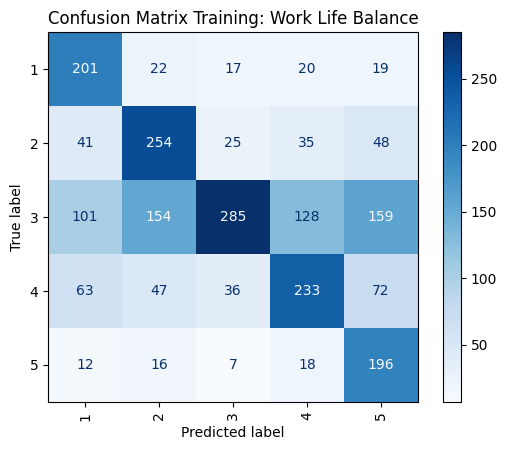

In [17]:
# Training Stats 
train_preds_wlb = best_wlb_clf.predict(X_train)

print("=== Training classification report ===")
print(classification_report(y1_train, train_preds_wlb))

print("=== Training confusion Matrix ===")
train_cm_wlb = confusion_matrix(y1_train, train_preds_wlb, labels = [1,2,3,4,5])
train_wlb_cm_display = ConfusionMatrixDisplay(
    train_cm_wlb, 
    display_labels=[1,2,3,4,5]
)

train_wlb_cm_display.plot(cmap = 'Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix Training: Work Life Balance')
plt.show()

classification report for work life balance 
               precision    recall  f1-score   support

           1       0.12      0.18      0.14       125
           2       0.24      0.27      0.25       169
           3       0.36      0.16      0.22       342
           4       0.20      0.19      0.20       204
           5       0.11      0.24      0.15       108

    accuracy                           0.20       948
   macro avg       0.21      0.21      0.19       948
weighted avg       0.24      0.20      0.20       948



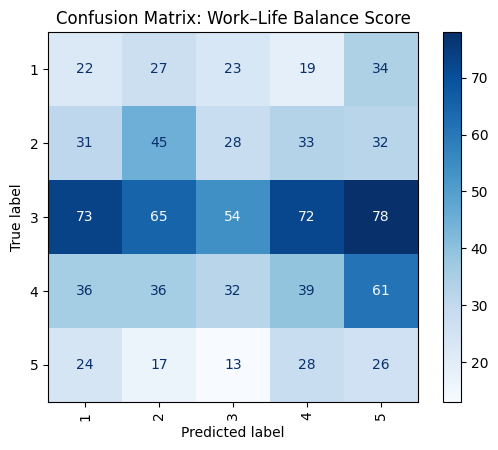

In [18]:
# Test Stats
preds_wlb = best_wlb_clf.predict(X_test)

print(f"classification report for work life balance \n {classification_report(y1_test, preds_wlb)}")

cm = confusion_matrix(y1_test, preds_wlb, labels=[1,2,3,4,5])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[1,2,3,4,5])

disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix: Work–Life Balance Score')
plt.show()

In [19]:
importances = pd.Series(
    best_wlb_clf.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)

print(importances.head(20))    # top 20
print(importances.tail(10))    # lowest 10

Age                                0.220950
Hours_Per_Week                     0.202691
Burnout_Level                      0.053758
Work_Arrangement_Onsite            0.032665
Mental_Health_Status_ADHD          0.027623
Gender_Male                        0.025849
Industry_Finance                   0.022968
Salary_Range_$80K-100K             0.021900
Industry_Professional Services     0.021515
Salary_Range_$60K-80K              0.020991
Mental_Health_Status_Anxiety       0.020661
Mental_Health_Status_Depression    0.018646
Gender_Female                      0.016472
Work_Arrangement_Remote            0.016407
Mental_Health_Status_PTSD          0.016355
Mental_Health_Status_None          0.013300
Mental_Health_Status_Burnout       0.013094
Region_Asia                        0.012906
Work_Arrangement_Hybrid            0.012714
Industry_Manufacturing             0.011409
dtype: float64
Job_Role_Quality Assurance      0.002764
Job_Role_Technical Writer       0.000000
Job_Role_Executive Assi

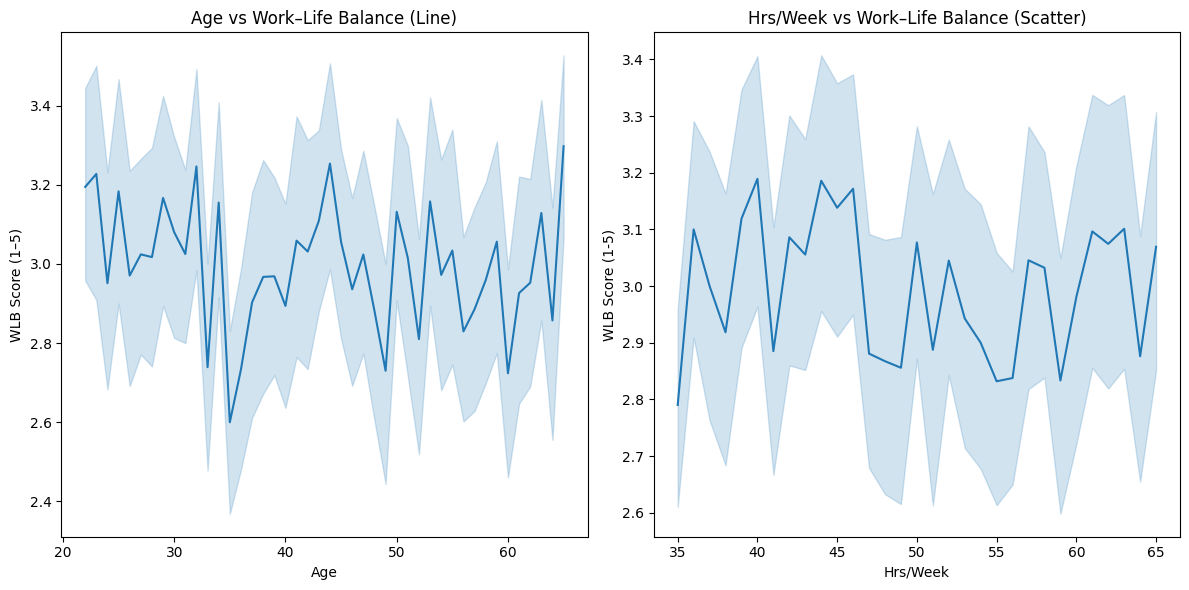

In [20]:
# Check Age Against important features
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

sns.lineplot(
    x='Age',
    y='Work_Life_Balance_Score',
    data=df,
    ax=axes[0]
)

axes[0].set_title("Age vs Work–Life Balance (Line)")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("WLB Score (1–5)")

# — Right
sns.lineplot(
    x='Hours_Per_Week',
    y='Work_Life_Balance_Score',
    data=df,
    ax=axes[1]
)
axes[1].set_title("Hrs/Week vs Work–Life Balance (Scatter)")
axes[1].set_xlabel("Hrs/Week")
axes[1].set_ylabel("WLB Score (1-5)")

plt.tight_layout()
plt.show()

plt.show()

#### Model 3: Try some Random Forest

In [27]:
# quickly balance classes 

smote = SMOTE() 

X_wlb_train_resampled, y1_train_resampled = smote.fit_resample(X_train, y1_train)

print(f"Resampled Shaped X Train: {X_wlb_train_resampled.shape}")
print(f"Resampled WLB target shape: {y1_train_resampled.shape}")
print("\n === New Values Counts ===")
print(y1_train_resampled.value_counts())

Resampled Shaped X Train: (4135, 61)
Resampled WLB target shape: (4135,)

 === New Values Counts ===
Work_Life_Balance_Score
3    827
4    827
5    827
2    827
1    827
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_grid = RandomForestClassifier(random_state=42)

# Set up GridSearch 
rf_parameter_grid = {
    'max_depth': [15, 20, 30, 40, 50, 70], 
    'n_estimators': [100,200,300,400,500],
    'max_features': [4, 6, 8, 10, 12], # total features 61
    'min_samples_leaf': [6,8,10]
}

rf_grid = GridSearchCV(rf_grid, rf_parameter_grid, cv = 5, scoring = 'accuracy', verbose = 3)
model_grid = rf_grid.fit(X_wlb_train_resampled, y1_train_resampled)

print(f'Best hyperparamters: {str(model_grid.best_params_)}')
print(f'Best Score is: {str(model_grid.best_score_)}')

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
[CV 1/5] END max_depth=15, max_features=4, min_samples_leaf=6, n_estimators=100;, score=0.203 total time=   0.1s
[CV 2/5] END max_depth=15, max_features=4, min_samples_leaf=6, n_estimators=100;, score=0.312 total time=   0.1s
[CV 3/5] END max_depth=15, max_features=4, min_samples_leaf=6, n_estimators=100;, score=0.452 total time=   0.1s
[CV 4/5] END max_depth=15, max_features=4, min_samples_leaf=6, n_estimators=100;, score=0.464 total time=   0.1s
[CV 5/5] END max_depth=15, max_features=4, min_samples_leaf=6, n_estimators=100;, score=0.482 total time=   0.1s
[CV 1/5] END max_depth=15, max_features=4, min_samples_leaf=6, n_estimators=200;, score=0.204 total time=   0.1s
[CV 2/5] END max_depth=15, max_features=4, min_samples_leaf=6, n_estimators=200;, score=0.307 total time=   0.1s
[CV 3/5] END max_depth=15, max_features=4, min_samples_leaf=6, n_estimators=200;, score=0.452 total time=   0.2s
[CV 4/5] END max_depth=15, max_f

In [31]:
results = pd.DataFrame(rf_grid.cv_results_)

results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.049832,0.006026,0.003660,0.000138,3,4,6,100,"{'max_depth': 3, 'max_features': 4, 'min_sampl...",0.209190,0.296252,0.391778,0.376058,0.383313,0.331318,0.070008,340
1,0.090306,0.000488,0.005753,0.000278,3,4,6,200,"{'max_depth': 3, 'max_features': 4, 'min_sampl...",0.215236,0.293833,0.395405,0.384522,0.405079,0.338815,0.073454,269
2,0.150655,0.003846,0.008996,0.000840,3,4,6,300,"{'max_depth': 3, 'max_features': 4, 'min_sampl...",0.210399,0.295042,0.400242,0.397823,0.408706,0.342443,0.078078,235
3,0.186894,0.005359,0.011201,0.001059,3,4,6,400,"{'max_depth': 3, 'max_features': 4, 'min_sampl...",0.209190,0.286578,0.395405,0.385732,0.422007,0.339782,0.079814,260
4,0.225133,0.004447,0.012867,0.000565,3,4,6,500,"{'max_depth': 3, 'max_features': 4, 'min_sampl...",0.207981,0.291415,0.401451,0.384522,0.413543,0.339782,0.078685,260


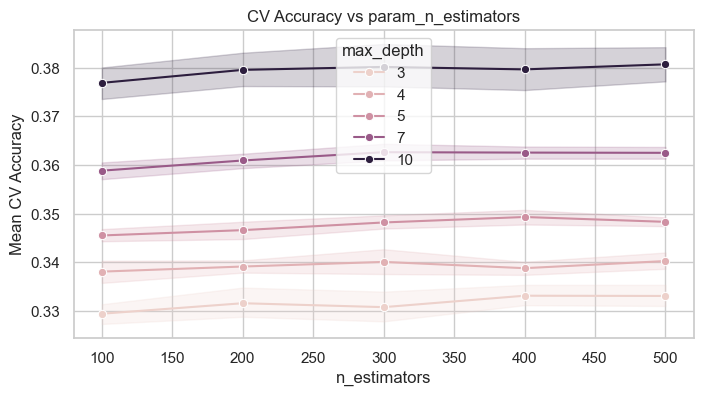

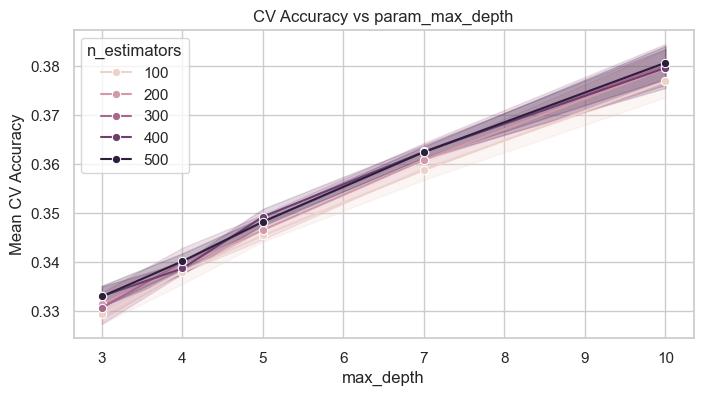

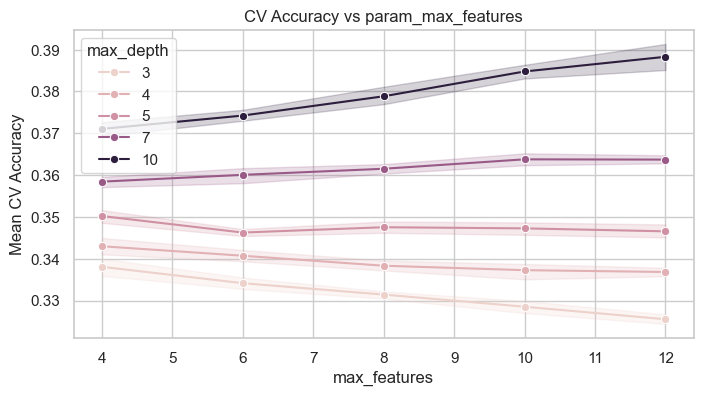

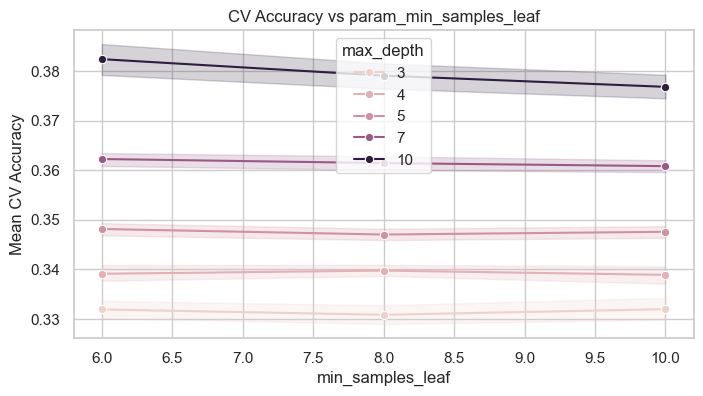

In [32]:
param_cols = [
    'param_n_estimators', 
    'param_max_depth',
    'param_max_features', 
    'param_min_samples_leaf'
]

sns.set_theme(style= 'whitegrid')

for param in param_cols: 
    plt.figure(figsize = (8,4))
    sns.lineplot(
        data = results, 
        x = param, 
        y = 'mean_test_score', 
        hue = 'param_max_depth' if param!='param_max_depth' else 'param_n_estimators',
        marker = 'o'
    )
    plt.title(f'CV Accuracy vs {param}')
    plt.xlabel(param.replace('param_', ''))
    plt.ylabel('Mean CV Accuracy')
    plt.legend(title=('max_depth' if param!='param_max_depth' else 'n_estimators'))
    plt.tight_layout
    plt.show()